## Frequentist of Bayesian measurement?
This notebook aims to understand the different behavior between a likelihood and a bayesian estimator, and in particular their *bias*. It reproduces the example illustred in the *Galaxy Shape Measurment* paper [Miller et al.](https://arxiv.org/pdf/0708.2340.pdf), Figure 1.

The authors used a Bayesian estimator for their model-fitting algorithm, arguing that **for a given set of measurements the Bayesian estimator yields the best estimate of the input values**. They illustrated this point with the following example.

Let us consider a Bayesian estimator $\hat{x}_{\mathcal{B}} = \int x p(x|y) dx$ and a Likelihood estimator $\hat{x}_{\mathcal{L}} = \int x \mathcal{L}(y|x) dx$ (mean posterior and mean likelihood estimators).

Let us assume that: 
- the intrinsic distribution of $x$ has a normal distribution of variance $a^2$, i.e. $x\sim\mathcal{N}(0, a^2)$ (*prior*),
- for each $x$ drawn from this distribution the measurement process causes a normally distributed uncertainty of variance $b^2$, i.e. $y|x \sim \mathcal{N}(x, b^2)$ (*likelihood*).

Then we can easily compute the *posterior* distribution $p(x|y)$ using the Bayes formula: $p(x|y)=\dfrac{\mathcal{L}(y|x)p(x)}{\int \mathcal{L}(y|x')p(x')dx'}$

The results are obtained in a Monte Carlo realisation for the illustrative case $a=0.3$ and $b=0.4$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
a = 0.3
b = 0.4

# parameter to estimate x (e.g. galaxy intrinsic properties) x ~ N(0, a^2)
x_input = np.random.normal(loc=0, scale=a, size=10000)

In [3]:
# measurments (observations) from which we want to fit the parameters y|x ~ N(x, b^2)
y = np.random.normal(loc=x_input, scale=b)

For each $x_\text{input}$, compute its likelihood $\hat{x}_\mathcal{L}$ and bayesian $\hat{x}_\mathcal{B}$ estimate with the *Monte Carlo method*.

[Monte Carlo Method](http://ib.berkeley.edu/labs/slatkin/eriq/classes/guest_lect/mc_lecture_notes.pdf): The expected value of a function $g$ of a random variable $X$, i.e. $\mathbb{E}[g(X)] = \int g(x) f_X(x) dx$ (where $f_X$ is the p.d.f. of $X$), can be approximated by the mean of $g(x)$ over samples of $X$, i.e. $x\sim X$.

In other words $$\tilde{g}_n(X) = \dfrac{1}{n}\sum_{i=1}^n g(x_i),$$ where the $x_{i\in [[1, n]]}$ are samples from $X$ with p.d.f. $f_X$, is the *Monte Carlo estimate* of $\mathbb{E}[g(X)] = \int g(x) f_X(x) dx$.

In this example we can analyticaly compute the likelihood $\mathcal{L}(y|x)$ and the posterior $p(x|y)$ distributions:
- *likelihood*: $y|x \sim \mathcal{N}\left(x, b^2\right)$
- *posterior*: $x|y \sim \mathcal{N}\left(y\dfrac{a^2}{a^2+b^2}, \dfrac{a^2+b^2}{a^2 b^2}\right)$ (intermediary result: $y\sim \mathcal{N}\left(0, \frac{1}{a^2+b^2}\right)$)

In [4]:
n = 10000

# Likelihood estimator
xi_L = np.random.normal(loc=y, scale=b, size= (n, y.shape[0])) # sample the x_is
x_L = np.mean(xi_L, axis=0) # Monte Carlo average g = identity

# Bayesian estimator
xi_B = np.random.normal(loc=y*(a**2)/(a**2+b**2), scale=np.sqrt((a**2+b**2))/a*b, size=(n, y.shape[0]))
x_B = np.mean(xi_B, axis=0)

Visualizing the results

In [5]:
from sklearn.linear_model import LinearRegression

x_input = x_input.reshape(-1, 1)
x_L = x_L.reshape(-1, 1)
x_B = x_B.reshape(-1, 1)

reg_L_estimate = LinearRegression().fit(x_L, x_input)
print("Input w.r.t. likelihood estimation: reg coef {:.2f} => biased".format(reg_L_estimate.coef_[0][0]))

reg_L_input = LinearRegression().fit(x_input, x_L)
print("Likelihood estimation w.r.t. input: reg coef {:.2f} => unbiased".format(reg_L_input.coef_[0][0]))

reg_B_estimate = LinearRegression().fit(x_B, x_input)
print("Input w.r.t. Bayesian estimation: reg coef {:.2f} => unbiased".format(reg_B_estimate.coef_[0][0]))

reg_B_input = LinearRegression().fit(x_input, x_B)
print("Bayesian estimation w.r.t. input: reg coef {:.2f} => biased".format(reg_B_input.coef_[0][0]))

Input w.r.t. likelihood estimation: reg coef 0.36 => biased
Likelihood estimation w.r.t. input: reg coef 1.01 => unbiased
Input w.r.t. Bayesian estimation: reg coef 0.99 => unbiased
Bayesian estimation w.r.t. input: reg coef 0.36 => biased


As Miller et al. concluded, we observe that
- For a given input value, the likelihood estimator yields an unbiased estimate (regression slope unity) whereas the Bayesian estimator appears biased (regression slope 0.35).
- For a given estimated value, the likelihood estimator is biased (regression slope 0.36) and the Bayesian estimator is unbiased.

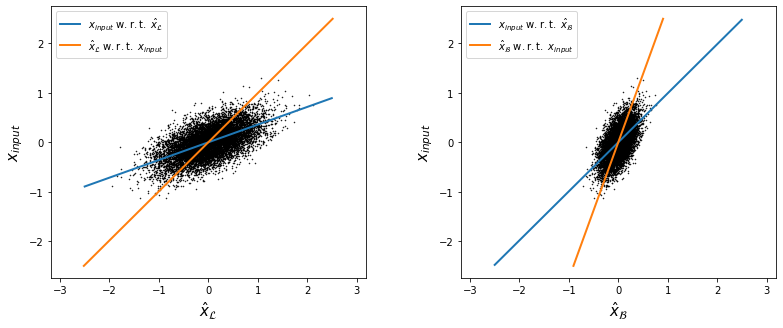

In [6]:
plt.figure(figsize=(13, 5))
plt.subplots_adjust(wspace = .3)

plt.subplot(121)
plt.scatter(x_L, x_input, marker=".", c='black', s=1)
plt.plot([-2.5, 2.5], [-2.5*reg_L_estimate.coef_[0][0], 2.5*reg_L_estimate.coef_[0][0]], linewidth=2, label="$x_{input}~\mathrm{w.r.t.}~\hat{x}_{\mathcal{L}}$")
plt.plot([-2.5*reg_L_input.coef_[0][0], 2.5*reg_L_input.coef_[0][0]], [-2.5, 2.5], linewidth=2, label="$\hat{x}_{\mathcal{L}}~\mathrm{w.r.t.}~x_{input}$")
plt.xlabel("$\hat{x}_\mathcal{L}$", fontsize=15)
plt.ylabel("$x_{input}$", fontsize=15)
plt.xlim(-1.5,  1.5)
plt.ylim(-1.5, 1.5)
plt.axis("equal")
plt.legend()

plt.subplot(122)
plt.scatter(x_B, x_input, marker=".", c='black', s=1)
plt.plot([-2.5, 2.5], [-2.5*reg_B_estimate.coef_[0][0], 2.5*reg_B_estimate.coef_[0][0]], linewidth=2, label="$x_{input}~\mathrm{w.r.t.}~\hat{x}_{\mathcal{B}}$")
plt.plot([-2.5*reg_B_input.coef_[0][0], 2.5*reg_B_input.coef_[0][0]], [-2.5, 2.5], linewidth=2, label="$\hat{x}_{\mathcal{B}}~\mathrm{w.r.t.}~x_{input}$")
plt.xlabel("$\hat{x}_\mathcal{B}$", fontsize=15)
plt.ylabel("$x_{input}$", fontsize=15)
plt.xlim(-1.5,  1.5)
plt.ylim(-1.5, 1.5)
plt.axis("equal")
plt.legend()
plt.show()

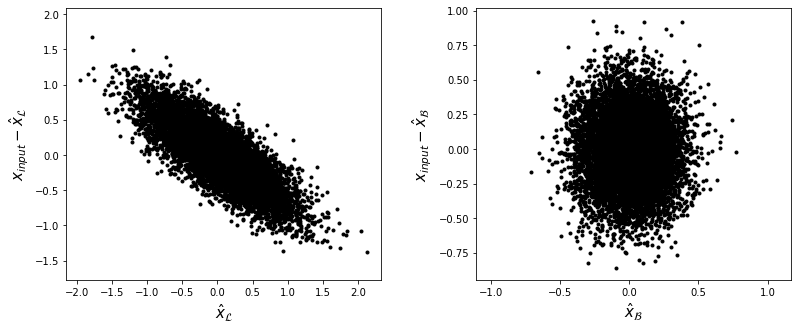

In [7]:
plt.figure(figsize=(13, 5))
plt.subplots_adjust(wspace = .3)
plt.subplot(121)
plt.scatter(x_L, x_input-x_L, marker=".", c='black')
plt.xlabel("$\hat{x}_\mathcal{L}$", fontsize=15)
plt.ylabel("$x_{input} - \hat{x}_\mathcal{L}$", fontsize=15)
plt.xlim(-1.5,  1.5)
plt.ylim(-1.5, 1.5)
plt.axis("equal")
plt.subplot(122)
plt.scatter(x_B, x_input-x_B, marker=".", c='black')
plt.xlabel("$\hat{x}_\mathcal{B}$", fontsize=15)
plt.ylabel("$x_{input} - \hat{x}_\mathcal{B}$", fontsize=15)
plt.xlim(-1.5,  1.5)
plt.ylim(-1.5, 1.5)
plt.axis("equal")
plt.show()

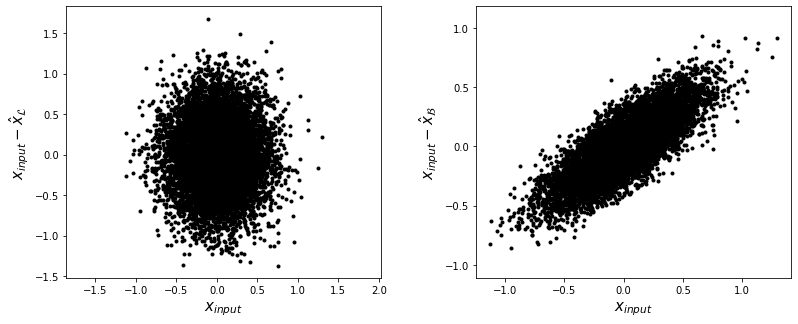

In [8]:
plt.figure(figsize=(13, 5))
plt.subplots_adjust(wspace = .3)
plt.subplot(121)
plt.scatter(x_input, x_input-x_L, marker=".", c='black')
plt.xlabel("$x_{input}$", fontsize=15)
plt.ylabel("$x_{input} - \hat{x}_\mathcal{L}$", fontsize=15)
plt.xlim(-1.5,  1.5)
plt.ylim(-1.5, 1.5)
plt.axis("equal")
plt.subplot(122)
plt.scatter(x_input, x_input-x_B, marker=".", c='black')
plt.xlabel("$x_{input}$", fontsize=15)
plt.ylabel("$x_{input} - \hat{x}_\mathcal{B}$", fontsize=15)
plt.xlim(-1.5,  1.5)
plt.ylim(-1.5, 1.5)
plt.axis("equal")
plt.show()